In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = '17_model'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
if not os.path.isfile(merge_file):
    dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
    df = pd.concat(dfs)
    df.to_parquet(merge_file)
else:
    df = pd.read_parquet(merge_file)

In [17]:
df = df.rename(columns={
    'global_features': 'round features',
    'round_number': 'round number',
    'update_step': 'training step',
})

In [18]:
non_labels = ['round number', 'sampling', 'training step', 'metric', 'value', 'job_id', 'run']

labels = [c for c in df.columns if c not in non_labels]

In [19]:
labels

['edge', 'round features', 'rnn']

In [24]:
import statsmodels.formula.api as smf
w = (
    (df['metric'] == 'common_good') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['training step'] > (0.8 * dfs['training step'].max()))
dfs = dfs[w_max].copy()

for l in labels:
    dfs[l] = dfs[l].astype(str)


label_ref = {
    'eps': '0.1',
    'gamma': '1.0',
    'lr': '3.e-4',
    'memory_episodes': '100',
    'target_update_freq': '100',
    'hidden_size': '5',
    'features': 'contributions'
}


label_str = [f"C('{l}', Treatment(reference='{label_ref[l]}'))" if l in label_ref else f"Q('{l}')" for l in labels]


results = smf.glm(f"value ~ {'*'.join(label_str)}", data=dfs).fit()
results_df = results.summary2().tables[1]
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,24.028874,0.037214,645.690640,0.000000e+00,23.955936,24.101813
Q('edge')[T.True],-1.428669,0.052629,-27.146114,2.814108e-162,-1.531820,-1.325518
Q('round features')[T.True],-0.047445,0.052629,-0.901504,3.673206e-01,-0.150596,0.055706
Q('rnn')[T.True],1.354328,0.052629,25.733568,4.923752e-146,1.251178,1.457479
Q('edge')[T.True]:Q('round features')[T.True],1.839008,0.074428,24.708401,8.687415e-135,1.693131,1.984885
Q('edge')[T.True]:Q('rnn')[T.True],1.464771,0.074428,19.680256,3.183889e-86,1.318894,1.610648
Q('round features')[T.True]:Q('rnn')[T.True],0.092126,0.074428,1.237778,2.157983e-01,-0.053751,0.238003
Q('edge')[T.True]:Q('round features')[T.True]:Q('rnn')[T.True],-1.905924,0.105258,-18.107212,2.795522e-73,-2.112225,-1.699622


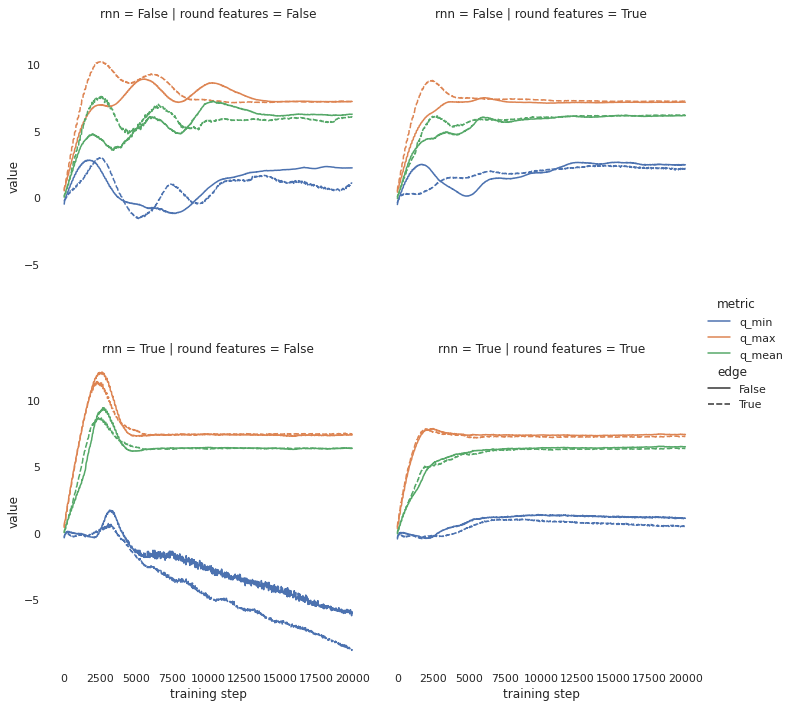

In [25]:
selection = {
    'eps': 0.2, 'gamma': 1, 'hidden_size': 20, 'lr': '3.e-4', 
    'memory_episodes': 100, 'sampling': 'greedy', 
    'target_update_freq': 200, 'features': 'contributions',
    'artificial_humans': 'complex'}

focus = ['training step', 'metric', *labels]

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

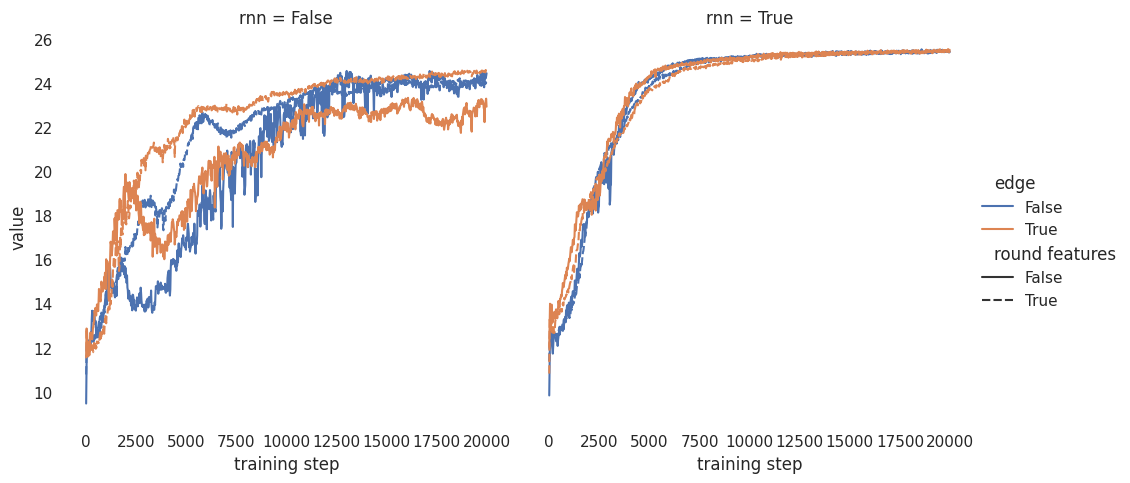

In [26]:
focus = ['training step', *labels]

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

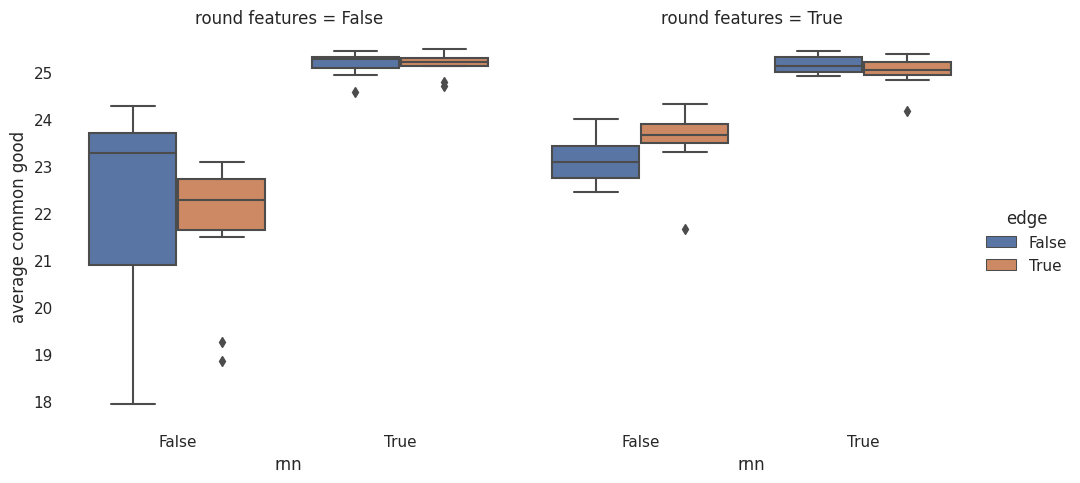

In [30]:
focus = [labels[2],labels[0],labels[1]]

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]

w_max = (dfs['training step'] > 8000) & (dfs['training step'] < 12000)
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels + ['run'])['value'].mean().reset_index()

fg = sns.catplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')

fg.set(ylabel='average common good')

fg.savefig(os.path.join(plot_folder, 'average_common_good.jpg'))